# Clustering of drawn components in galaxy builder

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
from PIL import Image
from astropy.io import fits
from skimage.transform import rotate, rescale

In [3]:
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False
classifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5638 entries, 0 to 5637
Data columns (total 14 columns):
classification_id    5638 non-null int64
user_name            5638 non-null object
user_id              4041 non-null float64
user_ip              5638 non-null object
workflow_id          5638 non-null int64
workflow_name        5638 non-null object
workflow_version     5638 non-null float64
created_at           5638 non-null object
gold_standard        0 non-null float64
expert               0 non-null float64
metadata             5638 non-null object
annotations          5638 non-null object
subject_data         5638 non-null object
subject_ids          5638 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 616.7+ KB


In [4]:
subjectId = 21096878

In [5]:
url = eval(
    subjects
        [subjects['subject_id'] == subjectId]
        ['locations']
        .iloc[0]
)['1']
print('URL of galaxy image:')
print(url)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/666eb138-4237-49cb-a1c6-57bc2b826bc8.png


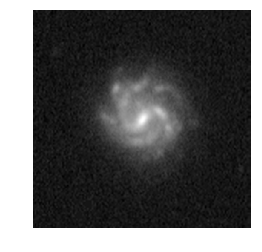

In [6]:
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)
plt.imshow(pic, origin='lower', cmap='gray')
plt.axis('off')
None

In [53]:
annotationsForSubject = [
    eval(foo) for foo in
    classifications[classifications['subject_ids'] == subjectId]['annotations']
]
disks = [a[0] for a in annotationsForSubject]
bulges = [a[1] for a in annotationsForSubject]
bars = [a[2] for a in annotationsForSubject]

(-0.5, 511.5, -0.5, 511.5)

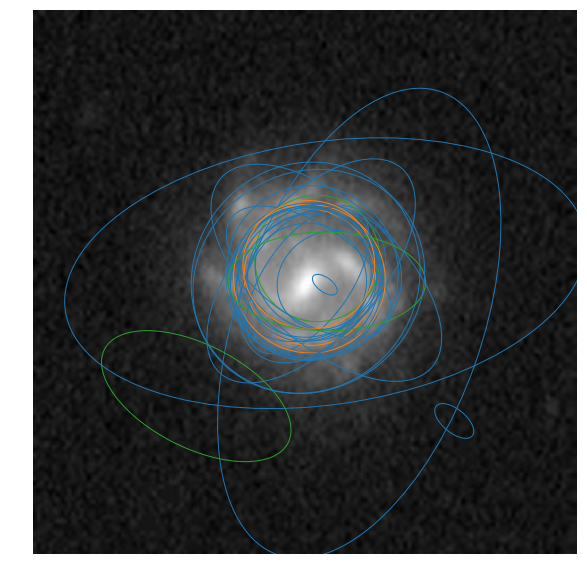

In [58]:
drawnDisks = pd.DataFrame([
    d['value'][0]['value'][0]
    for d in disks
    if len(d['value'][0]['value']) > 0
])
plt.figure(figsize=(10, 10))
ax=plt.gca()
plt.imshow(pic, origin='lower', cmap='gray')
for index, disk in drawnDisks.iterrows():
    e = Ellipse(
        xy=(disk['x'], disk['y']),
        width=disk['rx'],
        height=disk['ry'],
        angle=disk['angle'],
        ec='C{}'.format(disk['frame']),
        fc='none',
    )
    ax.add_artist(e)
plt.axis('off')

In [61]:
centers = np.array([drawnDisks['x'], drawnDisks['y']]).T

ratios = np.array(drawnDisks['rx'] / drawnDisks['ry'])

angles = np.array(drawnDisks['angle'])
angles[ratios < 1] += 90
angles = angles % 180

bas = ratios.copy()
bas[ratios > 1] = 1 / ratios[ratios > 1]

(array([10.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2., 13.]),
 array([0.5       , 0.54885022, 0.59770043, 0.64655065, 0.69540086,
        0.74425108, 0.79310129, 0.84195151, 0.89080172, 0.93965194,
        0.98850215]),
 <a list of 10 Patch objects>)

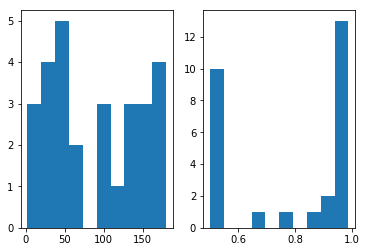

In [62]:
plt.subplot(121)
plt.hist(angles)
plt.subplot(122)
plt.hist(bas)

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
db = DBSCAN(eps=30)
l = db.fit_predict(centers)

center_outlier_mask = l > -1